Attempting to scale normalized probability counts grows exponentially
You can use Multi Layer Perceptrons (MLPs) as a solution to maximize the log-likelihood of the training data.
MLPs let you make predictions by embedding words close togehter in a space such that knowledge transfer of interchangability can occur with good confidence.

With a vocabulary of 17000 we use a lookup table of some dimension, say 30, so each lookup for a word provides a 30-dimensional embedding vector for that word.
To look up 3 words we would have 3 embedding vectors each with 30 neurons making up 90 neurons in total.  
Let C represent this lookup table.

Then we have a hidden layer of the NN which has a size that is represented by a hyperparameter.  They hyperparameter can have different sizes which we will evaluate as part of this exercise. Most of the compute happense between this hidden layer and the next layer which is the softmax.

The softmax returns logits which represents a normalized distribution of the 17000 words with probabilities which reflect the likelihood of the next word.

The parameters of the NN are weights and biases for the output layer, the weights and biases of the hidden layer and the lookup table C.




In [925]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [926]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [927]:
len(words)

32033

In [928]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


We are using a block_size which as the comment below suggests is how many characters we take to predict the next one

In [929]:
block_size = 3 
num_neurons = 16
num_features = 32
num_steps = 200000

In [930]:
# build the dataset


X, Y = [], []
for w in words[:5]:
  
  #print(w)
  context = [0] * block_size
  for ch in w + '.':
    ix = stoi[ch]
    X.append(context)
    Y.append(ix)
    print(''.join(itos[i] for i in context), '--->', itos[ix])
    context = context[1:] + [ix] # crop and append
  
X = torch.tensor(X)
Y = torch.tensor(Y)

... ---> e
..e ---> m
.em ---> m
emm ---> a
mma ---> .
... ---> o
..o ---> l
.ol ---> i
oli ---> v
liv ---> i
ivi ---> a
via ---> .
... ---> a
..a ---> v
.av ---> a
ava ---> .
... ---> i
..i ---> s
.is ---> a
isa ---> b
sab ---> e
abe ---> l
bel ---> l
ell ---> a
lla ---> .
... ---> s
..s ---> o
.so ---> p
sop ---> h
oph ---> i
phi ---> a
hia ---> .


In [931]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([32, 3]), torch.int64, torch.Size([32]), torch.int64)

We are going to squeeze the 27 characters into a 2-dimensional embedding

In [932]:
C = torch.randn((27, 2))

fun with C

In [933]:
C[5]

tensor([-2.1671,  1.6242])

In [934]:
C[[5,6,7,7,9,9]]

tensor([[-2.1671,  1.6242],
        [ 0.6562, -0.8205],
        [-1.1047, -0.6296],
        [-1.1047, -0.6296],
        [-0.8815, -1.3404],
        [-0.8815, -1.3404]])

In [935]:
C[torch.tensor([5,6,7])]

tensor([[-2.1671,  1.6242],
        [ 0.6562, -0.8205],
        [-1.1047, -0.6296]])

In [936]:
X.shape
X[228140:]

tensor([], size=(0, 3), dtype=torch.int64)

In [937]:
F.one_hot(torch.tensor(5), num_classes=27).float() @ C

tensor([-2.1671,  1.6242])

we split the training set into 3 splits
Xtr, Ytr (training split)
Xdev, Ydev (dev split)
Xte, Yte (test split)

In [938]:
# build the dataset

def build_dataset(words):  
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])


torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [939]:
emb = C[X]
emb.shape

torch.Size([32, 3, 2])

hidden layer W1 weights we initialize randomly 
number of inputs is 3 * 2 (2 dimensional embeddings, 3 of them) = 6
number of neurons is up to us 100 as an example


In [940]:
W1 = torch.randn((6, 100))
b1 = torch.randn(100)

the problem is we take the input
emb @ W1 + b1 
but the problem is these dimensions are stacked up in the tensor
shapes are  [32, 3, 2] and W1 is [6, 100]
we need to concat the inputs 

static way to concat

In [941]:
torch.cat([emb[:, 0, :], emb[:, 1, :], emb[:, 2, :]], 1).shape

torch.Size([32, 6])

dynamic way to concat
!! CAUTION this creates new memory, better to use .view()

In [942]:
torch.cat(torch.unbind(emb, 1), 1).shape

torch.Size([32, 6])

a.view()

In [943]:
a = torch.arange(18)

In [944]:
a.shape

torch.Size([18])

In [945]:
a.view(3,2,3)

tensor([[[ 0,  1,  2],
         [ 3,  4,  5]],

        [[ 6,  7,  8],
         [ 9, 10, 11]],

        [[12, 13, 14],
         [15, 16, 17]]])

In [946]:
a.storage()

 0
 1
 2
 3
 4
 5
 6
 7
 8
 9
 10
 11
 12
 13
 14
 15
 16
 17
[torch.storage.TypedStorage(dtype=torch.int64, device=cpu) of size 18]

In [947]:
emb.view(32, 6) == torch.cat(torch.unbind(emb, 1), 1)

tensor([[True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, T

the -1 in emb.view(-1, 6) tells pytorch to infer the first param automatically
we want to tanh to get our h to make numbers between -1 and 1


In [948]:
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)

In [949]:
h

tensor([[-0.8107, -0.9604, -0.9923,  ..., -1.0000, -0.9935, -0.9999],
        [-0.8546,  0.9451,  0.9996,  ..., -0.9999,  0.9979, -0.9997],
        [-0.9999, -1.0000, -0.6355,  ..., -0.8527,  0.9874, -0.9660],
        ...,
        [-0.3615, -0.9647,  0.9989,  ..., -0.7988,  0.9953, -0.9860],
        [-0.3583,  0.9666,  0.6565,  ...,  0.9977,  0.9867,  0.9356],
        [-0.7801,  0.9981,  0.7163,  ..., -0.9764,  0.9846, -0.9979]])

In [950]:
h.shape

torch.Size([32, 100])

In [952]:
(emb.view(-1, 6) @ W1).shape

torch.Size([32, 100])

In [953]:
b1.shape

torch.Size([100])

32, 100
1 , 100 
the 1 is automatically filled in so the same bias vector will be added to each row of the matrix 


In [954]:
W2 = torch.randn((100, 27))
b2 = torch.randn(27)

In [955]:
logits = h @ W2 + b2

In [ ]:
logits.shape

torch.Size([32, 27])

this would create another array for counts, probs and loss.  better to use a function cross_entropy to be more efficient and numerically well behaved

In [956]:
counts = logits.exp()

In [957]:
prob = counts / counts.sum(1, keepdims=True)

In [958]:
prob.shape

torch.Size([32, 27])

recall, Y is the next character in the sequence we'd like to predict

In [959]:
loss = -prob[torch.arange(32), Y].log().mean()
loss

tensor(20.0351)

In [960]:
# ------------ now made respectable :) ---------------

In [961]:
Xtr.shape, Ytr.shape # dataset

(torch.Size([182625, 3]), torch.Size([182625]))

C is embedding lookup table
    we have 27 possible characters
    we are going to embed them in a lower dimensional space (10) "feature vector"
        The feature vector represents different aspects of the character.  They are learned but could be initialized using prior knowledge of semantic features.
        Similar letters will have a similar feature vector.  A small change in the features will induce a small change in the probability, not only for that character but also of its combinatorial number of "neighbours" in character space (as represented by sequences of feature vectors)

W1 is the hidden layer it's size is (block_size * feature_vector, num_neurons) num_neurons is a number we can play with




In [962]:

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, num_features), generator=g)
W1 = torch.randn((block_size * num_features, num_neurons), generator=g)
b1 = torch.randn(num_neurons, generator=g)
W2 = torch.randn((num_neurons, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [ ]:
C[5]

tensor([-1.2801,  0.0924,  0.1053, -0.3907, -0.4009,  0.5653, -1.5065,  1.2898,
        -1.5100,  1.0930,  1.0797, -0.0867,  1.3423,  0.1518,  0.2469,  0.3190,
        -0.9861, -0.2138, -0.0643, -0.8553,  0.1611,  0.4493,  0.8183, -0.8163,
        -0.3924, -0.7452, -0.9465, -0.1594, -1.5047,  0.8468, -0.0492,  0.0939,
        -0.6453,  1.2108, -0.7820,  0.3845, -0.8526,  1.0464, -1.8493,  0.9109,
        -0.9936,  0.6019, -0.1089,  0.5259, -0.9405, -0.1277, -0.2568, -1.5437,
         0.3795, -1.7705])

In [ ]:
sum(p.nelement() for p in parameters) # number of parameters in total

1733

In [963]:
for p in parameters:
  p.requires_grad = True

In [ ]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [ ]:
lri = []
lossi = []
stepi = []

cross_entropy pytorch will cluster up the operations and very often create fused kernels that evaluate the expressions
the backward pass is also much more efficient analytically and mathematically 
from https://stackoverflow.com/questions/56601075/what-is-a-fused-kernel-or-fused-layer-in-deep-learning
"Fusing" means commonalization of computation steps. Basically, it's an implementation trick to run code more efficiently by combining similar operations in a single hardware (GPU, CPU or TPU) operation. Therefore, a "fusedLayer" is a layer where operations benefit from a "fused" implementation.

cross_entropy is more well behaved when logits take on more extreme values where we run out of range on the floating point number


minibatching is much better to have an approximate gradient and take more steps than an exact gradient and fewer steps

we want to find a reasonable learning rate
to do this you can play around with exponential learning rates and then plot the learning rate vs loss 
you look for a stable min value in this chart and that should give you a fairly good learning rate 

In [964]:
for i in range(200000):
    ix = torch.randint(0, Xtr.shape[0], (32,))
    break;
Xtr.shape

torch.Size([182625, 3])

forwarding and backwarding tens of thousands of examples is too much work
so we construct a minibatch of the data randomly selected

this minibatch will generate 32 samples between 0 and Xtr.shape[0] (182441)
we use these 32 samples to index into the X training set at those indicies, we use the same 32 samples to also index into Y training set

In [ ]:
C.shape

torch.Size([27, 50])

In [ ]:
for i in range(num_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (33,))
  
  # forward pass
  emb = C[Xtr[ix]] # (32, 3, 10)
  h = torch.tanh(emb.view(-1, block_size * num_features) @ W1 + b1) # (32, 200)
  logits = h @ W2 + b2 # (32, 27)
  loss = F.cross_entropy(logits, Ytr[ix])
  
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  #lr = lrs[i]
  lr = 0.1 if i < 100000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  #lri.append(lre[i])
  stepi.append(i)
  lossi.append(loss.log10().item())

print(loss.item())

2.603187084197998


In [ ]:
logits.max(1)

torch.return_types.max(
values=tensor([3.7384, 3.7384, 2.3683, 1.5418, 2.3683, 1.9706, 2.3683, 3.0268, 2.3683,
        2.3683, 4.3449, 4.3415, 2.3683, 1.5418, 3.8273, 2.3683, 2.3683, 3.7383,
        2.6416, 1.5418, 3.7774, 3.6200, 1.5418, 4.4386, 3.6045, 2.3683, 2.3683,
        1.5418, 3.7384, 3.3945, 1.5671, 3.8849, 4.4387],
       grad_fn=<MaxBackward0>),
indices=tensor([ 1,  1,  1, 14,  1, 14,  1,  0,  1,  1,  0,  0,  1, 14,  0,  1,  1,  1,
         0, 14,  0,  1, 14,  0,  0,  1,  1, 14,  1,  0, 14,  0,  0]))

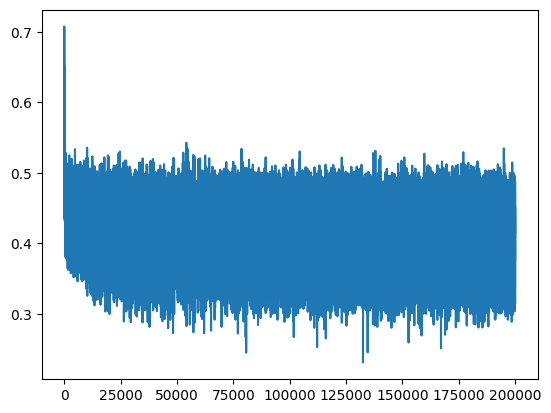

In [ ]:
plt.plot(stepi, lossi)

models can get larger and larger as you add parameters
as the capacity of the NN grows it becomes more and more capable of overfitting your training set
that is, it will have very low loss and will only give you back examples from your training set
then when you explore the loss on examples that are outside of the training set, you get loss that is very high

the standard in the field is to split up the data into 3 splits 
1) training split 80%
2) dev / validation split  10%
3) test split 10%

the dev/validation split is used to tune hyperparamaters for example size of hidden layer or embedding

the test split is evaluated very sparingly because you risk overfitting your data again



In [ ]:
emb = C[Xtr] # (32, 3, 2)
h = torch.tanh(emb.view(-1, block_size * num_features) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.5676, grad_fn=<NllLossBackward0>)

In [ ]:
emb = C[Xdev] # (32, 3, 2)
h = torch.tanh(emb.view(-1, block_size * num_features) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.5619, grad_fn=<NllLossBackward0>)

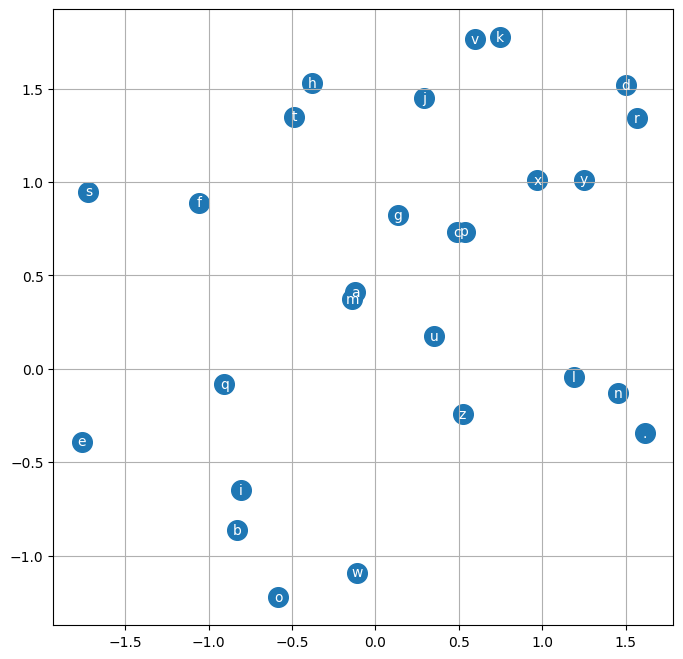

In [ ]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

In [ ]:
# training split, dev/validation split, test split
# 80%, 10%, 10%

In [ ]:
context = [0] * block_size
C[torch.tensor([context])].shape

torch.Size([1, 3, 50])

In [ ]:


# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))

careah.
aal.
hlelhi.
mri.
reh.
ykhalasane.
rahnen.
amesyht.
areei.
aranni.
tceriiv.
aslegy.
hham.
edin.
esintis.
lilea.
jadbi.
oraerogiiaryii.
jkjenni.
rat.
